In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevels = percents = [0.1, 0.01]

alpha = 1 # proximal term coefficient


num_resources = 50
num_agents = num_participants = 100

filename = "local_resal_N%d_%s_n%d_m%d"%(num_points, ",".join(list(map(str, eps_sublevels))), num_agents, num_resources)

In [4]:

num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
true_x, true_f, true_lamb = mra.centralized_solution_resal(A_all, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-91.86415947258942


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.000000020813085

In [7]:
true_lamb.shape, true_x.shape

((50, 1), (5000, 1))

In [8]:
fun_agents_eps = {}
fun_agents_noisy_y = {}
for eps in percents:
    fun_agents_eps[eps] = []
    fun_agents_noisy_y[eps] = []
    for i in range(num_agents):
        fun_agents_eps[eps] += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions(lamb_k, i, A_all, 
                                                                           eps_sublevel=eps, K=K, return_best=True)]
        fun_agents_noisy_y[eps] += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions_noisy_prices(lamb_k, i, A_all,
                                                                        percent=eps, K=K)]


fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# Localization

In [9]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [10]:
all_results_eps = {}
all_results_noisy_y = {}
for eps in percents:
    print(f"{eps=}")
    all_results_noisy_y[eps]  = mra.price_localization_primal_recovery(fun_agents_noisy_y[eps], fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]
    
    all_results_eps[eps]  = mra.price_localization_primal_recovery(fun_agents_eps[eps], fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]



eps=0.1


/Users/tepars/Documents/postdoc/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.2437E-02,  viol_xk=4.2108E+02, viol_mra=4.0289E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=7.7578E-02,  f_subopt_mra=2.3396E-02,  viol_xk=1.1819E+02, viol_mra=6.3912E+01, lamb_rel_diff=1.4778E-01
epoch=100, f_subopt_xk=4.0686E-02,  f_subopt_mra=6.6764E-04,  viol_xk=6.5719E+01, viol_mra=1.7423E+01, lamb_rel_diff=5.8679E-02
epoch=150, f_subopt_xk=6.6875E-03,  f_subopt_mra=1.2671E-03,  viol_xk=2.7223E+01, viol_mra=1.7901E-01, lamb_rel_diff=1.5109E-02
epoch=199, f_subopt_xk=2.1162E-03,  f_subopt_mra=1.5260E-03,  viol_xk=8.6204E+00, viol_mra=2.6886E-02, lamb_rel_diff=7.9546E-03
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.2588E-03,  viol_xk=4.2108E+02, viol_mra=2.9336E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=7.7578E-02,  f_subopt_mra=1.5115E-02,  viol_xk=1.1819E+02, viol_mra=8.4113E+00, lamb_rel_diff=1.4778E-01
epoch=100, f_subopt_xk=4.0686E-02,  f_subopt_mra=3.4999E-03,  viol_xk=6.5719E+01, viol_mra=1.1899E+00, lamb_rel_diff=5.8679E

In [11]:
eps = max(percents)
if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
    all_res = all_results_noisy_y[eps]
else:
    all_res = all_results_eps[eps]

In [12]:
for i, eps in enumerate(percents):
      print(np.array(all_res["viol_primal_xk"])[-1] / b_norm,
      "sub_eps", np.array(all_results_eps[eps]["viol_primal_mra_xk"])[-1] / b_norm,
      "noisy_y", np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"])[-1] / b_norm)

0.03179387091112002 sub_eps 3.6102833087808444e-11 noisy_y 2.8818345908991124e-13
0.03179387091112002 sub_eps 1.5092354740913507e-13 noisy_y 2.191411779043833e-12


In [13]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [6]:
import pickle


with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    eps = max(percents)
    if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
        all_res = all_results_noisy_y[eps]
    else:
        all_res = all_results_eps[eps]
# res["eps"].keys()

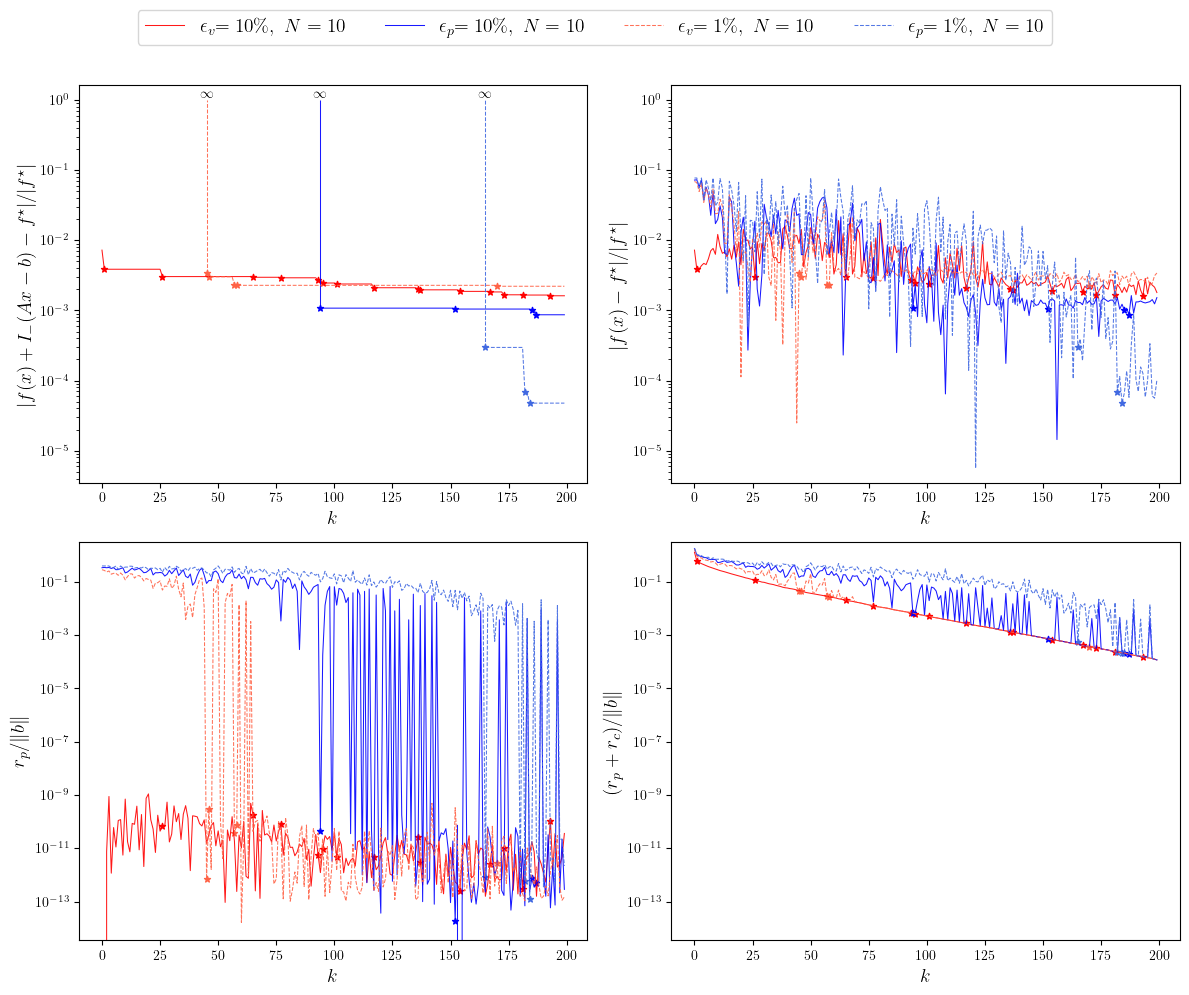

In [7]:
mra.plot_eps_all_metrics_4x(all_results_eps, all_results_noisy_y, num_points, true_f, b_norm, percents, filename)

In [9]:
for eps in percents:
    print(f"{eps=}")
    eps_subopt = (np.abs(np.array(all_results_eps[eps]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    eps_res = np.array(all_results_eps[eps]["viol_primal_mra_xk"]) / b_norm
    noisy_y_subopt = (np.abs(np.array(all_results_noisy_y[eps]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    noisy_y_res = np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"]) / b_norm

    res_tol = 1e-6
    print("eps", np.where(eps_res < res_tol)[0][0],  "noisy_y", np.where(noisy_y_res < res_tol)[0][0])

    eps_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_eps[eps], true_f, b_norm),)
    noisy_y_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_noisy_y[eps], true_f, b_norm),)

    print(f"eps {eps_subopt[-1]*100}\%  noisy_y {noisy_y_subopt[-1]*100}\%")

eps=0.1
eps 0 noisy_y 94
eps 0.16213080722543732\%  noisy_y 0.0868701475793295\%
eps=0.01
eps 45 noisy_y 165
eps 0.2215515537250867\%  noisy_y 0.004770553255409349\%
